In [1]:
#1. Import Libraries

In [2]:
#step 1 - import all libraries for data handling, feature extraction, clustering and plotting
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [3]:
#2. Data Loading Functions

In [4]:
#step 2 - define function to load tweets data from the Dataset folder
def load_tweets_data():
    #use relative path
    tweets_data = pd.read_csv("../Dataset/tweets.csv")
    return tweets_data

In [5]:
#step 3 - define function to load NRC emotion lexicon from the Lexicon folder
def load_nrc_lexicon():
    #use relative path
    lexicon_path = "../Lexicon/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"
    lexicon = {}
    with open(lexicon_path, "r", encoding="utf-8") as file:
        for line in file:
            parts = line.strip().split('\t')
            if len(parts) == 3:
                word, emotion, value = parts
                if word not in lexicon:
                    lexicon[word] = {}
                lexicon[word][emotion] = int(value)
    return lexicon

In [6]:
#testing of 2. Data Loading Functions
tweets = load_tweets_data()
lexicon = load_nrc_lexicon()
print(tweets.head())
print(list(lexicon.items())[:5])

   id                                               link  \
0   0  https://twitter.com/HackneyPSC/status/17274436...   
1   1  https://twitter.com/cherrysattitude/status/172...   
2   2  https://twitter.com/diamoundgirls2/status/1710...   
3   3  https://twitter.com/mmtchi/status/172764634165...   
4   4  https://twitter.com/NoahIeeNG/status/172744319...   

                                                text              date  likes  \
0  A statement from psychoanalytic activists:  Th...  11/22/2023 21:47      0   
1                        bak bak bak bak doyamadınız  11/22/2023 15:27    443   
2  Check out 🏒 35 + different ERIK KARLSSON cards...    10/7/2023 7:15      0   
3  Il s'en passe des trucs pendant qu'on vous ori...  11/23/2023 11:12    381   
4  AW OKAY.. WELL THATS COOL, IM SURE PAL WILL AP...  11/22/2023 21:45      0   

   comments  
0         0  
1         9  
2         0  
3        44  
4         0  
[('aback', {'anger': 0, 'anticipation': 0, 'disgust': 0, 'fear': 0, 

In [7]:
#3. Data Preprocessing

In [8]:
#step 1 - define function to preprocess the tweets data
def preprocess_tweets_data(tweets_data):
    #remove rows with missing tweets
    tweets_data = tweets_data.dropna(subset=["text"]).copy()
    #convert text to lowercase for consistency
    tweets_data["text"] = tweets_data["text"].str.lower()
    #remove links
    tweets_data["text"] = tweets_data["text"].apply(lambda x: re.sub(r"http\S+|www\S+|https\S+", "", x))
    return tweets_data

In [9]:
#testing
tweets = load_tweets_data()
tweets = preprocess_tweets_data(tweets)
print(tweets.head())

   id                                               link  \
0   0  https://twitter.com/HackneyPSC/status/17274436...   
1   1  https://twitter.com/cherrysattitude/status/172...   
2   2  https://twitter.com/diamoundgirls2/status/1710...   
3   3  https://twitter.com/mmtchi/status/172764634165...   
4   4  https://twitter.com/NoahIeeNG/status/172744319...   

                                                text              date  likes  \
0  a statement from psychoanalytic activists:  th...  11/22/2023 21:47      0   
1                        bak bak bak bak doyamadınız  11/22/2023 15:27    443   
2  check out 🏒 35 + different erik karlsson cards...    10/7/2023 7:15      0   
3  il s'en passe des trucs pendant qu'on vous ori...  11/23/2023 11:12    381   
4  aw okay.. well thats cool, im sure pal will ap...  11/22/2023 21:45      0   

   comments  
0         0  
1         9  
2         0  
3        44  
4         0  


In [10]:
#4. Feature Extraction

In [11]:
#step 1 - extract username from twitter link
def extract_username(link):
    match = re.search(r"twitter\.com/([^/]+)/status", str(link))
    if match: 
        return match.group(1)
    else:
        return "unknown"

#step 2 - a function to count emoji in text
def count_emojis(text):
    emoji_pattern = re.compile(
    r"[\U0001F600-\U0001F64F"
    r"\U0001F300-\U0001F5FF"
    r"\U0001F680-\U0001F6FF"
    r"\U0001F1E0-\U0001F1FF]+", flags=re.UNICODE)
    return len(emoji_pattern.findall(str(text)))

#step 3 - function to count hashtags
def count_hashtags(text):
    return len(re.findall(r"#\w+", str(text)))

#step 4 - function to get tweet length (num of characters)
def get_tweet_length(text):
    return len(str(text))

#step 5 - function to count emotional words using NRC lexicon
def count_emotion_words(text, lexicon, emotion):
    words = str(text).split()
    count = 0 
    for word in words:
        if word in lexicon and lexicon[word].get(emotion, 0) == 1:
            count += 1
    return count

#step 6 - main function to extract all features for each tweet
def extract_features(tweets_data, lexicon):
    #extract username from link
    tweets_data["username"] = tweets_data["link"].apply(extract_username)
    #create feature columns for emoji, hashtags, tweet length, likes and comments
    tweets_data["emoji_count"] = tweets_data["text"].apply(count_emojis)
    tweets_data["hashtag_count"] = tweets_data["text"].apply(count_hashtags) 
    tweets_data["tweet_length"] = tweets_data["text"].apply(get_tweet_length)
    #convert like and comment columns to numeric
    tweets_data["likes"] = pd.to_numeric(tweets_data["likes"], errors="coerce").fillna(0)
    tweets_data["comments"] = pd.to_numeric(tweets_data["comments"], errors="coerce")
    #add NRC emotion features one column per emotion
    emotions = ["anger", "anticipation", "disgust", "fear", "joy", "sadness", "surprise", "trust", "positive", "negative"]
    for emotion in emotions:
        tweets_data[f"emotion_{emotion}_count"] = tweets_data["text"].apply(lambda x: count_emotion_words(x, lexicon, emotion))
    return tweets_data

In [12]:
#testing
tweets = extract_features(tweets, lexicon)
print(tweets[["username", "text", "emoji_count", "hashtag_count", "likes", "comments"]].head())

          username                                               text  \
0       HackneyPSC  a statement from psychoanalytic activists:  th...   
1  cherrysattitude                        bak bak bak bak doyamadınız   
2   diamoundgirls2  check out 🏒 35 + different erik karlsson cards...   
3           mmtchi  il s'en passe des trucs pendant qu'on vous ori...   
4        NoahIeeNG  aw okay.. well thats cool, im sure pal will ap...   

   emoji_count  hashtag_count  likes  comments  
0            0              0      0         0  
1            0              0    443         9  
2            1              4      0         0  
3            0              1    381        44  
4            0              0      0         0  


In [13]:
#5. Aggregation to User level 

In [14]:
#step 1 - define function to aggregate tweet-level features to user-level
def aggregate_to_user_level(tweets_data):
    #group by username and calculate mean of numeric features for each user
    user_features = tweets_data.groupby("username").agg({
        "emoji_count": "mean",
        "hashtag_count": "mean",
        "tweet_length": "mean",
        "likes": "mean",
        "comments": "mean",
        "emotion_anger_count": "mean",
        "emotion_anticipation_count": "mean",
        "emotion_disgust_count": "mean",
        "emotion_fear_count": "mean",
        "emotion_joy_count": "mean",
        "emotion_sadness_count": "mean",
        "emotion_surprise_count": "mean",
        "emotion_trust_count": "mean",
        "emotion_positive_count": "mean",
        "emotion_negative_count": "mean",
    }).reset_index()
    return user_features

In [15]:
#test
user_features = aggregate_to_user_level(tweets)
print(user_features.head())

      username  emoji_count  hashtag_count  tweet_length  likes  comments  \
0    001Flight          0.0            0.0          63.0    0.0       0.0   
1    0130Coach          0.0            0.0         453.0    0.0       0.0   
2       01IOTA          0.0            0.0         280.0   50.0       9.0   
3  021Scenario          0.0            0.0          40.0    0.0       0.0   
4        06Kiu          0.0            0.0          73.0  478.0      13.0   

   emotion_anger_count  emotion_anticipation_count  emotion_disgust_count  \
0                  0.0                         0.0                    0.0   
1                  1.0                         0.0                    0.0   
2                  2.0                         1.0                    1.0   
3                  0.0                         0.0                    0.0   
4                  0.0                         0.0                    0.0   

   emotion_fear_count  emotion_joy_count  emotion_sadness_count  \
0      

In [16]:
#6. Feature Scaling

In [17]:
#step 1 - define function to scale user features using Standard Scaler
def scale_features(user_features):
    #select only numeric columns for scaling - skip "username"
    feature_columns = user_features.columns.drop("username")
    scaler = StandardScaler()
    scaled_values = scaler.fit_transform(user_features[feature_columns])
    #create a new DataFrame with the scaled values + skipped "username"
    scaled_df = pd.DataFrame(scaled_values, columns=feature_columns)
    scaled_df["username"] = user_features["username"].values
    #return the scaled Dataframe
    return scaled_df

In [18]:
#test
scaled_df = scale_features(user_features)
print(scaled_df.head())

   emoji_count  hashtag_count  tweet_length     likes  comments  \
0    -0.216797      -0.275886     -0.398846 -0.115727 -0.086424   
1    -0.216797      -0.275886      0.913631 -0.115727 -0.086424   
2    -0.216797      -0.275886      0.331430 -0.109018 -0.061325   
3    -0.216797      -0.275886     -0.476248 -0.115727 -0.086424   
4    -0.216797      -0.275886     -0.365192 -0.051590 -0.050170   

   emotion_anger_count  emotion_anticipation_count  emotion_disgust_count  \
0            -0.449069                   -0.323141              -0.391037   
1             0.412821                   -0.323141              -0.391037   
2             1.274711                    0.615390               0.990815   
3            -0.449069                   -0.323141              -0.391037   
4            -0.449069                   -0.323141              -0.391037   

   emotion_fear_count  emotion_joy_count  emotion_sadness_count  \
0            0.232071          -0.316548              -0.442799   


In [19]:
#7. Clustering

In [20]:
#step 1 - function to apply KMeans 
def apply_kmeans(scaled_df, num_clusters=3):
    #selec numeric columns + skip username
    feature_columns = scaled_df.columns.drop("username")
    #create and fit KMneans
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(scaled_df[feature_columns])
    #add cluster labels to dataframe
    scaled_df["kmeans_cluster"] = cluster_labels
    #return dataframe and model
    return scaled_df, kmeans

#step 2 - function to apply DBSCAN clustering
def apply_dbscan(scaled_df, eps=1.0, min_samples=5):
    #select numeric columns + skip username and kmeans
    feature_columns = scaled_df.columns.drop(["username", "kmeans_cluster"], errors="ignore")
    #create and fit DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_labels = dbscan.fit_predict(scaled_df[feature_columns])
    #add cluster labels to dataframe
    scaled_df["dbscan_cluster"] = dbscan_labels
    #return
    return scaled_df, dbscan

In [21]:
#testing
#apply kmeans clustering + number of clusters
scaled_df, kmeans = apply_kmeans(scaled_df, num_clusters=2)

#apply dbscan clustering 
scaled_df, dbscan = apply_dbscan(scaled_df, eps=1.0, min_samples=5)

#results
print(scaled_df[["username", "kmeans_cluster", "dbscan_cluster"]].head())

      username  kmeans_cluster  dbscan_cluster
0    001Flight               1               0
1    0130Coach               0              -1
2       01IOTA               0               0
3  021Scenario               1               0
4        06Kiu               1               0


In [22]:
#8. Evaluation

In [23]:
#function to evaluate kmeans with silhouette score
def evaluate_kmeans(scaled_df):
    feature_columns = [col for col in scaled_df.columns if col not in ["username", "kmeans_cluster", "dbscan_cluster"]]
    #silhouette score
    labels = scaled_df["kmeans_cluster"]
    score = silhouette_score(scaled_df[feature_columns], labels)
    print("KMeans Silhouette Score:", round(score, 3))
    #cluster sizes
    print("KMeans Cluster Counts:\n", scaled_df["kmeans_cluster"].value_counts())
    #mean values per cluster
    print("KMeans Feature Means per Cluster:\n", scaled_df.groupby("kmeans_cluster")[feature_columns].mean())

#fn to evaluate dbscan 
def evaluate_dbscan(scaled_df):
    #print inclusing outliers (-1)
    print("DBSCAN Cluster Counts including Outliers:\n", scaled_df["dbscan_cluster"].value_counts())
    #mean values per cluster
    feature_columns = [col for col in scaled_df.columns if col not in ["username", "kmeans_cluster", "dbscan_cluster"]]
    print("DBSCAN Feature Means per Cluster:\n", scaled_df.groupby("dbscan_cluster")[feature_columns].mean())

#plot elbow method for KMeans
def plot_elbow_method(scaled_df, max_k=8):
    feature_columns = [col for col in scaled_df.columns if col not in ["username", "kmeans_cluster", "dbscan_cluster"]]
    inertia = []
    k_range = range(2, max_k+1)
    #fit KMeans for each value of k
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(scaled_df[feature_columns])
        inertia.append(kmeans.inertia_)
    #elbow curve plot
    plt.plot(list(k_range), inertia, marker='o')
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Inertia")
    plt.title("Elbow Method for KMeans")
    plt.show()

KMeans Silhouette Score: 0.509
KMeans Cluster Counts:
 kmeans_cluster
1    9250
0    1410
Name: count, dtype: int64
KMeans Feature Means per Cluster:
                 emoji_count  hashtag_count  tweet_length     likes  comments  \
kmeans_cluster                                                                 
0                 -0.006580       0.019672      0.576885  0.013351  0.087322   
1                  0.001003      -0.002999     -0.087936 -0.002035 -0.013311   

                emotion_anger_count  emotion_anticipation_count  \
kmeans_cluster                                                    
0                          1.375515                    0.837606   
1                         -0.209673                   -0.127678   

                emotion_disgust_count  emotion_fear_count  emotion_joy_count  \
kmeans_cluster                                                                 
0                            1.376271            1.265692            0.85861   
1                  

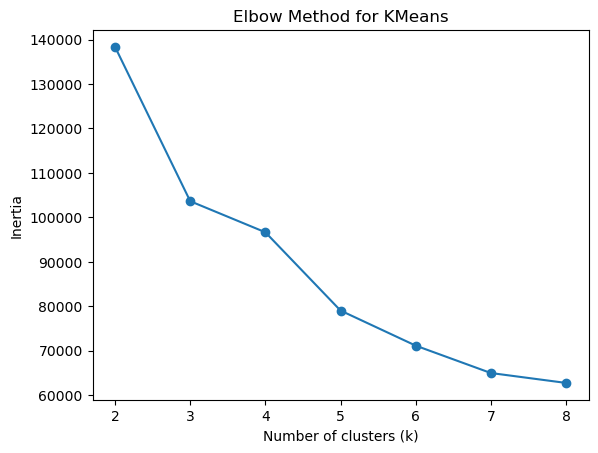

In [24]:
#check
evaluate_kmeans(scaled_df)
evaluate_dbscan(scaled_df)
plot_elbow_method(scaled_df)